## LSTM for time series forecasting 
Based on the article from Jason Brownlee.
https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

##### Shampoo Sales Dataset
This dataset describes the monthly number of sales of shampoo over a 3-year period.

The units are a sales count and there are 36 observations. The original dataset is credited to Makridakis, Wheelwright, and Hyndman (1998).

In [24]:
# forces tensorflow to run on the CPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt

In [25]:
# load dataset
def parser(x):
    return pd.datetime.strptime('201'+x, '%Y-%m')

df = pd.read_csv('shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
df.head()

Month
2011-01-01    266.0
2011-02-01    145.9
2011-03-01    183.1
2011-04-01    119.3
2011-05-01    180.3
Name: Sales, dtype: float64

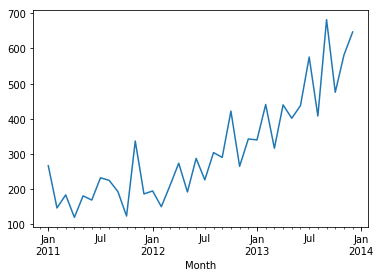

In [26]:
df.plot()

#### 1. Baseline model
Persistence Model Forecast.

The persistence forecast is where the observation from the prior time step (t-1) is used to predict the observation at the current time step (t).

In [27]:
# split data into train and test
values = df.values
train, test = values[0:-12], values[-12:]

RMSE: 136.761


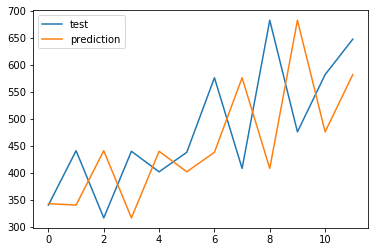

In [28]:
# walk-forward validation
history = train
predictions = np.zeros(len(test))
for i, x in enumerate(test):
    # make prediction
    predictions[i] = history[-1]
    # observation
    history = np.append(history, x)
# report performance
rmse = math.sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.plot(test, label='test')
plt.plot(predictions, label='prediction')
plt.legend()
plt.show()

#### 2. Transform the time series into a supervised learning problem

In [29]:
# create a differenced series
def difference(dataset, interval=1):
    diff = np.zeros(len(dataset) - 1)
    for i in range(interval, len(dataset)):
        diff[i - 1] = dataset[i] - dataset[i - interval]
    return diff


# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [30]:
# transform data to be stationary
diff_values = difference(values, 1)

In [31]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    assert lag >= 1
    df = pd.Series(data)
    columns = [df.shift(i) for i in range(1, lag + 1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [32]:
supervised = timeseries_to_supervised(diff_values, 1)
supervised.head()

,0,1
0,0.0,-120.1
1,-120.1,37.2
2,37.2,-63.8
3,-63.8,61.0
4,61.0,-11.8


In [33]:
# split data into train and test-sets
train, test = supervised.values[0:-12], supervised.values[-12:]

In [34]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train_scaled = scaler.transform(train)
    # transform test
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled


# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, -1)
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [35]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

#### 3. Fit and evaluate a LSTM model

In [43]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # build the model
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        # do not shuffle the training data points
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        # reset lstm states between batches
        model.reset_states()
        if i%100 == 0:
            print('epoch:', i)
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [37]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1500, 1)

epoch: 0
epoch: 50
epoch: 100
epoch: 150
epoch: 200
epoch: 250
epoch: 300
epoch: 350
epoch: 400
epoch: 450
epoch: 500
epoch: 550
epoch: 600
epoch: 650
epoch: 700
epoch: 750
epoch: 800
epoch: 850
epoch: 900
epoch: 950
epoch: 1000
epoch: 1050
epoch: 1100
epoch: 1150
epoch: 1200
epoch: 1250
epoch: 1300
epoch: 1350
epoch: 1400
epoch: 1450


In [38]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(-1, 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[-0.0259117 ],
       [ 0.22062802],
       [-0.27052507],
       [ 0.20124924],
       [-0.38115335],
       [-0.03336877],
       [-0.38554448],
       [-0.05381069],
       [ 0.04891688],
       [ 0.22062802],
       [-0.9679955 ],
       [ 0.22062802],
       [-0.14146113],
       [ 0.11105747],
       [-0.3770104 ],
       [-0.37605304],
       [ 0.22062802],
       [-0.53975844],
       [ 0.19552591],
       [-0.4568811 ],
       [-0.0227022 ],
       [-0.6982518 ],
       [ 0.22062802]], dtype=float32)

Month=1, Predicted=285.575427, Expected=339.700000
Month=2, Predicted=354.352449, Expected=440.400000
Month=3, Predicted=365.720837, Expected=315.900000
Month=4, Predicted=385.043404, Expected=439.300000
Month=5, Predicted=343.970006, Expected=401.300000
Month=6, Predicted=446.937525, Expected=437.400000
Month=7, Predicted=416.597136, Expected=575.500000
Month=8, Predicted=470.089867, Expected=407.600000
Month=9, Predicted=476.743404, Expected=682.000000
Month=10, Predicted=530.832030, Expected=475.300000
Month=11, Predicted=544.443404, Expected=581.300000
Month=12, Predicted=500.701015, Expected=646.900000
Test RMSE: 98.420


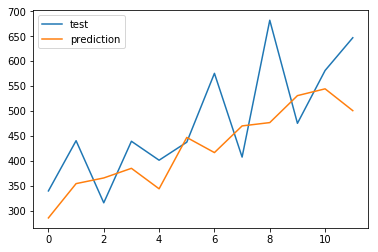

In [39]:
# walk-forward validation on the test data
predictions = []
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
 
# report performance
rmse = sqrt(mean_squared_error(values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.plot(values[-12:], label='test')
plt.plot(predictions, label='prediction')
plt.legend()
plt.show()

It shows a slightly better performance than the persistance model.
RMSE: 136.761

#### 4. Build a Robust Result
A difficulty with neural networks is that they give different results with different starting conditions.


One approach might be to fix the random number seed used by Keras to ensure the results are reproducible. Another approach would be to control for the random initial conditions using a different experimental setup.


We can repeat the experiment from the previous section multiple times, then take the average RMSE as an indication of how well the configuration would be expected to perform on unseen data on average.

This is often called multiple repeats or multiple restarts.


We can wrap the model fitting and walk-forward validation in a loop of fixed number of repeats. Each iteration the RMSE of the run can be recorded. We can then summarize the distribution of RMSE scores.

epoch: 0
epoch: 100
epoch: 200
epoch: 300
epoch: 400
epoch: 500
epoch: 600
epoch: 700
epoch: 800
epoch: 900
epoch: 1000
epoch: 1100
epoch: 1200
epoch: 1300
epoch: 1400
1) Test RMSE: 96.579
epoch: 0
epoch: 100
epoch: 200
epoch: 300
epoch: 400
epoch: 500
epoch: 600
epoch: 700
epoch: 800
epoch: 900
epoch: 1000
epoch: 1100
epoch: 1200
epoch: 1300
epoch: 1400
2) Test RMSE: 99.718
epoch: 0
epoch: 100
epoch: 200
epoch: 300
epoch: 400
epoch: 500
epoch: 600
epoch: 700
epoch: 800
epoch: 900
epoch: 1000
epoch: 1100
epoch: 1200
epoch: 1300
epoch: 1400
3) Test RMSE: 134.112
epoch: 0
epoch: 100
epoch: 200
epoch: 300
epoch: 400
epoch: 500
epoch: 600
epoch: 700
epoch: 800
epoch: 900
epoch: 1000
epoch: 1100
epoch: 1200
epoch: 1300
epoch: 1400
4) Test RMSE: 102.262
epoch: 0
epoch: 100
epoch: 200
epoch: 300
epoch: 400
epoch: 500
epoch: 600
epoch: 700
epoch: 800
epoch: 900
epoch: 1000
epoch: 1100
epoch: 1200
epoch: 1300
epoch: 1400
5) Test RMSE: 93.529
epoch: 0
epoch: 100
epoch: 200
epoch: 300
epoch: 400


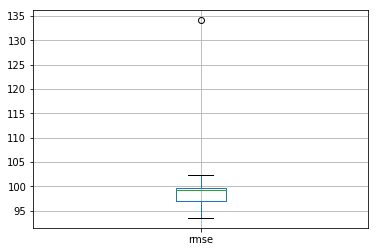

In [44]:
# repeat experiment
repeats = 10
error_scores = []
for r in range(repeats):
    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 1500, 1)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)
    # walk-forward validation on the test data
    predictions = []
    for i in range(len(test_scaled)):
    # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(values[-12:], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)

             rmse
count   10.000000
mean   101.695252
std     11.682286
min     93.529356
25%     96.957333
50%     99.213805
75%     99.705712
max    134.112396


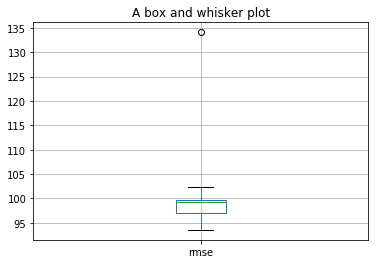

In [46]:
# summarize results
results = pd.DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
plt.title('A box and whisker plot')
plt.show()